## Lighthouse Labs
### W05D1 Training and Evaluation


Instructor: Socorro Dominguez  
July 19, 2021

## Overview
- Training models
    - Overfitting
    - Train-test split
    - Sampling bias
    - Cross-validation
    - Hyperparameter tuning
        - Grid search
- Model evaluation
    - Regression
    - Classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(style='darkgrid', context='talk')
import matplotlib.pyplot as plt

# Suppress some warnings that sklearn is returning when a model doesn't perform well
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# Training models

## Overfitting


- Imagine studying for an exam using a set of practice questions
- If you do well on the practice questions, are you guaranteed to do well on the real exam?
- Goal is to *learn the underlying concepts* rather than *memorize the questions/answers*
- This is called **generalization**


![](images/overfitting.png)
- Data has two components: signal (pattern) + noise
- Example: predicting house prices from # of bedrooms, area, age, etc.
    - Signal: degree to which these features influence the price
    - Noise: random variation, or variation due to unknown features
- When the model is fitting the noise, it is overfitting
- Overfitting is undesirable: noise is random and doesn't behave the same on new data.
- **Why** does overfitting happen? Too complex.

## Test/train split


- If you were studying from practice exams, what would you do to get an idea of how you will perform on the real one?
- Idea:
    1. Learn from some practice exams that you do again and again (training data)
    2. Write a *new* practice exam that you left to the side (test data)
- This strategy will give you an idea of how well you will generalize



- With more powerful models, we can always arbitrarily fit the training data better and better (lower training error)
- What we're actually trying to achieve is good performance on **new data that our model was never trained on**
- We can train our model on just a subset of our whole dataset (**train set**) and evaluate its performance on the rest (**test set**)

<img src="images/test_set.png" style="width: 700px;"/>

![](images/overfitting_training.png)

### Train/test split example

In [2]:
# Load the dataset
from sklearn.datasets import load_boston
from sklearn.utils import shuffle

boston_data = load_boston()
X, y = boston_data['data'], boston_data['target']

# It is good practice to shuffle your data, since it
# may be ordered in a particular way (e.g. increasing target)
X, y = shuffle(X, y, random_state=27)

print(f'Dataset has {X.shape[0]} data points and {X.shape[1]} features')

Dataset has 506 data points and 13 features


In [3]:
# Make train/test split
# Let's use 70% of the data for training and evaluate on the remaining 30%
train_ratio = 0.7

X_train, X_test = X[:int(train_ratio * len(X))], X[int(train_ratio * len(X)):]
y_train, y_test = y[:int(train_ratio * len(y))], y[int(train_ratio * len(y)):]

print(f'{len(X_train)} training samples and {len(X_test)} test samples')

354 training samples and 152 test samples


In [4]:
# In practice, we can just use sklearn's convenience function for making the above split instead
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=train_ratio)

print(f'{len(X_train)} training samples and {len(X_test)} test samples')

354 training samples and 152 test samples


In [5]:
# Train our model
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [6]:
# Check performance on train and test set
from sklearn.metrics import r2_score

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Train R^2:\t{r2_train}\n\
Test R^2:\t{r2_test}')

Train R^2:	0.7278481991105032
Test R^2:	0.7500070318143862


#### Debrief
The test set performance is actually *similar* to the train set. Our model doesn't seem to be overfitting.

But the score is low... Perhaps we can use a more complex model and get even better performance on the test set. Let's try polynomial regression.

In [7]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial feature set and train model
polinomial = PolynomialFeatures(degree=2)

Xpoly_train = polinomial.fit_transform(X_train)
Xpoly_test = polinomial.transform(X_test)

print(f'Number of polynomial features: {Xpoly_train.shape[1]}')

# Predictions
reg.fit(Xpoly_train, y_train)
ypoly_train_pred = reg.predict(Xpoly_train)
ypoly_test_pred = reg.predict(Xpoly_test)

# Check performance on train and test set
r2poly_train = r2_score(y_train, ypoly_train_pred)
r2poly_test = r2_score(y_test, ypoly_test_pred)
print(f'Train R^2:\t{r2poly_train}\nTest R^2:\t{r2poly_test}')

Number of polynomial features: 105
Train R^2:	0.9295292900269387
Test R^2:	0.8343842458230977


Our more complex second-order polynomial regression model performed even better on the test set.
Our model might be overfitting, but we are not sure yet.
Let's bump up the complexity one more time and try 4-order polynomial regression.

In [8]:
# Create polynomial feature set and train model
poly4 = PolynomialFeatures(degree=4)
Xpoly3_train = poly4.fit_transform(X_train)
Xpoly3_test = poly4.transform(X_test)
print(f'Number of polynomial features: {Xpoly3_train.shape[1]}')

# Train our model
reg.fit(Xpoly3_train, y_train)
ypoly3_train_pred = reg.predict(Xpoly3_train)
ypoly3_test_pred = reg.predict(Xpoly3_test)

# Check performance on train and test set
r2poly3_train = r2_score(y_train, ypoly3_train_pred)
r2poly3_test = r2_score(y_test, ypoly3_test_pred)
print(f'Train R^2:\t{r2poly3_train}\nTest R^2:\t{r2poly3_test}')

Number of polynomial features: 2380
Train R^2:	1.0
Test R^2:	-224.91117921662797


Our more complex 4-order polynomial regression model did horribly on the test set. Notice that it overfits the training set completly (perfect prediction). 

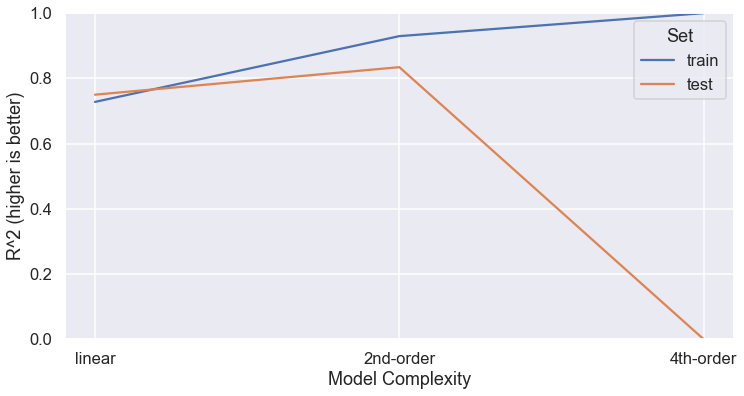

In [9]:
# Show performance of all models on train and test set
df = pd.DataFrame({'Model Complexity': ['linear', 'linear', '2nd-order', '2nd-order', '4th-order', '4th-order'],
                  'R^2': [r2_train, r2_test, r2poly_train, r2poly_test, r2poly3_train, r2poly3_test],
                  'Set': ['train', 'test', 'train', 'test', 'train', 'test']})
df['R^2'] = df['R^2'].clip(lower=0)    # Threshold minimum R^2 to 0 for nicer display of results (if it's 0, we already know it learned nothing)

plt.figure(figsize=(12, 6))
sns.lineplot(x='Model Complexity', y='R^2', hue='Set', data=df, sort=False)
plt.ylim(ymin=0, ymax=1)
plt.ylabel('R^2 (higher is better)')
plt.show()

## Sampling bias

- Remember that the model just learns patterns in the data you give it.
- If our dataset isn't representative of the type of data we want our model to handle afterwards, it is not going to perform well.
- Most machine learning models fail dramatically for **out of distribution** data that is very different from what we've trained on.



### Activity
Think of a **dataset** and machine learning **task** where:
- Our data was collected within a certain distribution (e.g. house prices in Toronto)
- We evaluate it on out of distribution data where it would fail (e.g. house prices in Tokyo)

Essentially **all** datasets are biased one way or another. Train yourself to think of different ways
that they could be biased and different reasons why. Understanding the conditions under which your model
will work and fail is essential when deploying it in the real world.

*Try and think creatively about real scenarios where the dataset would be biased because of where it came from!
(e.g. don't just say it only had house prices from Toronto, give a realistic explanation for why that might happen)*

<!--
- Old dataset from another decade
- One data-source (e.g. Creg's list). Very common problem which will cause bias from multiple sources. Instagram selfie example from ModiFace
- Different data processing (e.g. you forget to standardize the new data coming in like you did with your training data)
- Different data formats or devices. For images, different cameras. For audio, different microphones. For text, different writing medium
- Dataset too small (most common problem, since statistically small dataset is bound to be biased). Problem gets worse the more features we have
-->

## Cross-validation
- We wish to evaluate our model on a dataset with little sampling bias, so that we know how it will perform in the real world
- Smaller datasets are far more likely to suffer from sampling bias
- This creates a conflict:
    - We want to have a big test set to get a realistic estimate of our model's performance without sampling bias
    - We want to have a big training set so that our model can learn without sampling bias
- How can we reconcile these goals?
- **One answer:** cross-validation. Even if any single fold suffers from sampling bias, at least we are averaging the results from many


<img src="images/cross_validation.png" style="width: 1000px;"/>

### Cross-validation example

In [10]:
# Make the folds
k_folds = 5

X_folds, y_folds = np.array_split(X, k_folds), np.array_split(y, k_folds)

fold_sizes = ', '.join([str(len(f)) for f in X_folds])
print(f'The folds are of type {type(X_folds)} and contain {fold_sizes} data points')

The folds are of type <class 'list'> and contain 102, 101, 101, 101, 101 data points


In [11]:
# List that will accumulate test performance on each fold
cv_r2 = []

for i in range(k_folds):
    # Make the train/test set for this fold
    X_test = X_folds[i]
    y_test = y_folds[i]
    X_train = [X_folds[j] for j in range(k_folds) if j != i]
    y_train = [y_folds[j] for j in range(k_folds) if j != i]
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    
    # Train the model
    reg.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    y_pred = reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    cv_r2.append(r2)
    
print(cv_r2)

[0.7057189451172963, 0.6566041936444882, 0.7203026852522953, 0.7898705155348587, 0.7287877060675566]


In [12]:
# Get the mean and standard deviation of the cross-validation test set performance across folds
cv_r2 = np.array(cv_r2)
print(f'Cross-validated R^2\nMean:\t{cv_r2.mean()}\nStd.:\t{cv_r2.std()}')

Cross-validated R^2
Mean:	0.7202568091232989
Std.:	0.04285289109219576


Notice that this test set performance is actually lower than in our initial example when we split the
dataset once into a train/test set. We should trust this estimate more, because it was computed
from 5 different train/test splits rather than a single one.

**THINK:** Are we taking into consideration the Golden Rule here?

#### sklearn provides an [easy](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) way to do cross-validation

In [13]:
from sklearn.model_selection import KFold

# List that will accumulate test performance on each fold
cv_r2 = []

kf = KFold(n_splits=k_folds)

for train_idx, test_idx in kf.split(X):
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
    
    # Train the model
    reg.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    y_pred = reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    cv_r2.append(r2)
    
# Get the mean and standard deviation of the cross-validation test set performance across folds
cv_r2 = np.array(cv_r2)
print(f'Cross-validated R^2\nMean:\t{cv_r2.mean()}\nStd.:\t{cv_r2.std()}')

Cross-validated R^2
Mean:	0.7202568091232989
Std.:	0.04285289109219576


#### And an even [easier way](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) that even gets you the scores.

In [15]:
from sklearn.model_selection import cross_val_score

cv_r2 = cross_val_score(reg, X, y, cv=k_folds, scoring='r2')
print(f'Cross-validated R^2\nMean:\t{cv_r2.mean()}\nStd.:\t{cv_r2.std()}')

Cross-validated R^2
Mean:	0.7202568091232989
Std.:	0.04285289109219576


## Hyperparameter tuning
- Most models often have parameters that we must set, which are not learned during training. We call these **hyperparameters**
- For instance, Ridge Regression, which uses L2 regularization to prevent overfitting, requires us to set a λ parameter that balances the weight penalty vs. prediction error in the loss term
- If these hyperparameters are not learned during training, how do we learn them?
- The most common method amounts to, disappointingly, guess-and-check... We try a bunch of values for the hyperparameters and set them to whatever achieves the lowest loss
    - Common techniques: grid search, random search
    - More advanced techniques (that we won't look at): Bayesian optimization, genetic algorithms

### Grid search with cross-validation
- For each hyperparameter, specify a list of values we want to try
- Train a version of the model using each *combination* of hyperparameters
- Whichever combination achieves the lowest loss will be picked

<img src="images/grid_search.png" style="width: 1000px;"/>


- Our hyperparameters are often selected to prevent overfitting (e.g. λ for L2 regularization, learning rate, etc.)
- To select the best hyperparameters that prevent overfitting, we should be selecting the ones that give the best performance on some held out data
- For that reason, grid search is frequently combined with cross-validation, and we pick the hyperparameters that gave the best average validation performance across folds

#### Grid search with cross-validation example

In [16]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
# Scale features since weight magnitudes will effect regularization weight penalties
X_scaled = StandardScaler().fit_transform(X)
# Hyperparameter settings we want to try
alphas = [0.001, 0.01, 0.1, 1]
l1_ratios = [0, 0.25, 0.5, 0.75, 1]
# Keep track of the best hyperparameters found so far
best_r2 = -np.inf
best_alpha = None
best_l1_ratio = None

for alpha in alphas:
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=27)
        cv_r2 = cross_val_score(model, X_scaled, y, cv=k_folds, scoring='r2')
        if cv_r2.mean() > best_r2:
            best_r2 = cv_r2.mean()
            best_alpha = alpha
            best_l1_ratio = l1_ratio           
print(f'The best hyperparameter settings achieve a cross-validated\n\
R^2     : {round(best_r2,4)}\n\
Alpha   : {best_alpha}\n\
L1 ratio: {best_l1_ratio}')

The best hyperparameter settings achieve a cross-validated
R^2     : 0.7207
Alpha   : 0.01
L1 ratio: 0


#### As always, sklearn provides an [easier way](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [17]:
from sklearn.model_selection import GridSearchCV

# Make a dictionary with model arguments as keys and lists of grid settings as values
param_grid = {
              'alpha': [0.001, 0.01, 0.1, 1],
              'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
              }

grid = GridSearchCV(estimator = model, 
                    param_grid = param_grid,
                    cv = k_folds, 
                    scoring = 'r2', 
                    verbose=1, n_jobs=-1) # verbose=1 -> print results, n_jobs=-1 -> use all processors in parallel

grid_result = grid.fit(X_scaled, y)

best_r2 = grid_result.best_score_
best_alpha = grid_result.best_params_['alpha']
best_l1_ratio = grid_result.best_params_['l1_ratio']

print(f'The best hyperparameter settings achieve a cross-validated\n\
R^2     : {best_r2}\n\
Alpha   : {best_alpha}\n\
L1 ratio: {best_l1_ratio}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


The best hyperparameter settings achieve a cross-validated
R^2     : 0.7206816828526261
Alpha   : 0.01
L1 ratio: 0


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished


### Train / validation / test split

**Question**: Have you noticed anything wrong with what we are doing? Should we trust our cross-validation score as a true estimate of performance on out-of-sample data?

We cannot trust it. We have been using the cross-validation score to select hyperparameters. You can think of this as having used the validation data in each fold to train our model in a way. So, our model will be biased to the dataset and our cross-validation score will be overly-optimistic.

**Solution**:
1. Split the dataset into a train/test set
2. Perform grid search with cross-validation on the training set. Each fold, the training set will be split into a train/validation set
3. Using the hyperparameters that obtained the best cross-validation score, retrain the model on the entire training set (not just training folds within this training set)
4. Evaluate the model on the test set to get a true estimate of the out-of-sample error

<img src="images/cross_validation_with_test.png" style="width: 500px;"/>

Even then, we are violating our rule. It won't mess up your model terribly so, for now, we will proceed that way. However, in a future lesson you will learn about Pipelines. Pay attention there.

In [18]:
# Split data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=0.8)

param_grid = {
              'alpha': [0.001, 0.01, 0.1, 1],
              'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
              }

# Standardize the data using only statistics from the training set
# (always assume no knowledge of the test set for most unbiased performance estimate)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=k_folds, scoring='r2', verbose=1, n_jobs=-1) # verbose=1 -> print results, n_jobs=-1 -> use all processors in parallel
grid_result = grid.fit(X_train, y_train)

best_r2 = grid_result.best_score_
best_alpha = grid_result.best_params_['alpha']
best_l1_ratio = grid_result.best_params_['l1_ratio']
print(f'The best hyperparameter settings achieve a cross-validated\n\
R^2     : {best_r2}\n\
Alpha   : {best_alpha}\n\
L1 ratio: {best_l1_ratio}')


# Using the best hyperparameters, retrain on the entire train set and evaluate on the test set
best_model = grid_result.best_estimator_    # Sklearn automatically retrains the model on the whole training set following cross-validation using the best hyperparameters
y_pred = best_model.predict(X_test)
r2_test = r2_score(y_test, y_pred)

print(f'R^2 on the test set:\t{r2_test}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits
The best hyperparameter settings achieve a cross-validated
R^2     : 0.7171522166211203
Alpha   : 0.01
L1 ratio: 0
R^2 on the test set:	0.725493932307976


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


# Model evaluation

## Classification
- **Goal**: Predict between two or more discrete classes. For between two classes, called *binary* classification
- **Example**: Predict whether or not someone has cancer (binary), predict what object is shown in an image (multiclass)

### Accuracy
$$acc = \frac{\text{# of times correct}}{\text{# of predictions made}}$$

### Confusion matrix
Full detail about how model fails

| | Actual + | Actual - |
|-|-|-|
|Predicted + | True Positive | False Positive | 
|Predicted - | False Negative | True Negative |

<img src="images/multiclass_confusion_matrix.png" style="width: 300px; display: block; margin-left: auto; margin-right: auto"/>

#### In a binary case of 100 examples (50+, 50-), 95% accuracy:

| | Actual + | Actual - |
|-|-|-|
|Predicted + | 50| 5 | 
|Predicted - |0 | 45|

| | Actual + | Actual - |
|-|-|-|
|Predicted + | 45| 0 | 
|Predicted - |5 | 50|

- Which model would you rather have predicting...
    - **cancer diagnosis**? (positive means "has cancer")
    - **spam filtering**? (positive means "is spam")
    
**Conclusion**: How your model fails matters

### Metrics computed from binary confusion matrix

#### Recall: True positives / Condition positive
- We want high recall when we don't want to miss any positive conditions
- Good for something like cancer diagnosis

#### Precision: True positives / Detected or predicted positives
- We want high precision if the machine learning model is going to trigger some automated process
- Good for something like spam detection
- Low precision may be okay in cancer diagnosis, just run another test

#### F1 score: 2 * (Precision * Recall) / (Precision + Recall)
- Combine both precision and recall into a single general-purpose metric
- Useful for quickly comparing models
- There are variations that weight precision/recall unequally

## Regression

### Mean Squared Error
- Commonly used (especially as training loss)
- Large errors (from outliers) have disproportionate impact
- Units not intuitive
- Task-dependent (i.e. no maximum bound)

\begin{align}
    MSE &= \frac{1}{n} \sum_{i=0}^n (y_i - \hat{y}_i)^2 \\
        &= \frac{1}{n} (\mathbf{y} - \mathbf{\hat{y}})^T (\mathbf{y} - \mathbf{\hat{y}})
\end{align}

### Root Mean Squared Error
- Commonly used for evaluation, but not for training loss
- Large errors (from outliers) have disproportionate impact
- Units are intuitive
- Task-dependent (i.e. no maximum bound)

\begin{align}
    RMSE &= \sqrt{\frac{1}{n} \sum_{i=0}^n (y_i - \hat{y}_i)^2} \\
         &= \sqrt{\frac{1}{n} (\mathbf{y} - \mathbf{\hat{y}})^T (\mathbf{y} - \mathbf{\hat{y}})}
\end{align}

### Mean Absolute Error 
- Commonly used (especially as training loss, but less than Mean Squared Error)
- Outliers have less impact
- Units are intuitive
- Task-dependent (i.e. no maximum bound)

\begin{align}
    MAE &= \frac{1}{n} \sum_{i=0}^n |y_i - \hat{y}_i|
\end{align}



### Coefficient of Determination ($R^2$)
- Measures the proportion of the variation in your dependent variable (Y) explained by your independent variables (X)
- Commonly used for evaluation, but not for training loss
- Intuitive interpretation
- Task-independent (usually ranges from 0 to 1, although negative values can mean worse than most naive solution)
- *Adjusted $R^2$* variant adjusts the statistic based on the number of independent variables in the model

\begin{align}
    R^2 &= 1 - \frac{\text{Unexplained variance}}{\text{Total variance}} \\
        &= 1 - \frac{MSE_{model}}{MSE_{baseline}} \\
        &= 1 - \frac{(\mathbf{y} - \mathbf{\hat{y}})^T (\mathbf{y} - \mathbf{\hat{y}})}{(\mathbf{y} - \mathbf{y}_{avg})^T (\mathbf{y} - \mathbf{y}_{avg})}
\end{align}